In [8]:
import cv2
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
################# Initialize the paths #################

input_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Raw"  

output_drowsy_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Augment\\Drowsy"
output_non_drowsy_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Augment\\Non Drowsy"
output_dir_resize = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Resize"
parent_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Augment"
os.makedirs(output_drowsy_dir, exist_ok=True)
os.makedirs(output_non_drowsy_dir, exist_ok=True)
os.makedirs(output_dir_resize, exist_ok=True)
classes = ["Drowsy", "Non Drowsy"]

In [ ]:
################ Data Augmentation ###################

rotation_angles = [-10, 10 ]  

# Perform data augmentation for each class
for class_name in classes:
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = output_drowsy_dir if class_name == "Drowsy" else output_non_drowsy_dir

    
    file_list = os.listdir(class_input_dir)

    for file_name in file_list:
        if file_name.endswith(".png"):  
            
            img = cv2.imread(os.path.join(class_input_dir, file_name))

           
            for angle in rotation_angles:
                
                rotated_img = np.array(Image.fromarray(img).rotate(angle))

                
                output_file = os.path.join(class_output_dir, f"rotated_{angle}_{file_name}")
                cv2.imwrite(output_file, rotated_img)

           
            flipped_img = cv2.flip(img, 1)

            output_file = os.path.join(class_output_dir, f"flipped_{file_name}")
            cv2.imwrite(output_file, flipped_img)

In [ ]:
######################## Resize Images #########################

target_size = (227, 227)

for class_name in classes:
    class_dir = os.path.join(parent_dir, class_name)
    output_class_dir = os.path.join(output_dir_resize, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # List the files in the class directory
    file_list = os.listdir(class_dir)

    # Resize and pad each image
    for file_name in file_list:
        if file_name.endswith(".png"):
            
            img = Image.open(os.path.join(class_dir, file_name))

            
            img.thumbnail(target_size, Image.ANTIALIAS)

            
            new_img = Image.new("RGB", target_size, (255, 255, 255))

          
            left = (target_size[0] - img.width) // 2
            top = (target_size[1] - img.height) // 2

            
            new_img.paste(img, (left, top))

            
            output_file = os.path.join(output_class_dir, file_name)
            new_img.save(output_file)



In [ ]:
################ Calculate Mean and Standard deviation for z-score normalization ######################

parent_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Resize"
mean_accumulator = np.zeros((3,))
stddev_accumulator = np.zeros((3,))
total_images = 0

for class_name in classes:
    class_dir = os.path.join(parent_dir, class_name)

   
    file_list = os.listdir(class_dir)

    for file_name in file_list:
        if file_name.endswith(".png"): 
            
            img = cv2.imread(os.path.join(class_dir, file_name))

            
            img_float = img.astype(np.float32) / 255.0

            
            mean_accumulator += np.mean(img_float, axis=(0, 1))
            stddev_accumulator += np.std(img_float, axis=(0, 1))
            total_images += 1


overall_mean = mean_accumulator / total_images
overall_stddev = stddev_accumulator / total_images


In [ ]:
########## Apply z-score normalization #################

out_dir_nor = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Normalize"
def z_score_normalization(img):
    
    img_float = img.astype(np.float32) / 255.0

   
    normalized_img = (img_float - overall_mean) / overall_stddev

    
    normalized_img = np.clip(normalized_img, 0, 1)

    return normalized_img


for class_name in classes:
    class_dir = os.path.join(parent_dir, class_name)
    output_dir = os.path.join(out_dir_nor, f"{class_name}")
    os.makedirs(output_dir, exist_ok=True)

    
    file_list = os.listdir(class_dir)

    for file_name in file_list:
        if file_name.endswith(".png"):  
            
            img = cv2.imread(os.path.join(class_dir, file_name))

            
            normalized_img = z_score_normalization(img)

         
            output_file = os.path.join(output_dir, file_name)
            cv2.imwrite(output_file, (normalized_img * 255).astype(np.uint8))


In [ ]:
############## Encoding and Data Sequencing for CRNN ##############

parent_dir = "C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\Normalize"

# Initialize lists to store image data and labels
data = []
labels = []


max_sequence_length = 227  


for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(parent_dir, class_name)

    
    file_list = os.listdir(class_dir)

    for file_name in file_list:
        if file_name.endswith(".png"):  
           
            img = cv2.imread(os.path.join(class_dir, file_name))

           
            img_sequence = img.reshape(-1, img.shape[1], img.shape[2]) 

            
            data.append(img_sequence)

           
            label = 1 if class_name == "Drowsy" else 0
            labels.append(label)  


data = np.array(data)
labels = np.array(labels)


data_padded = pad_sequences(data, maxlen=max_sequence_length, padding="post", truncating="post")




In [ ]:
### Model Train ######

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()


model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Reshape((112, 112 * 32))) 
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(64, activation='relu'))


model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(data_padded, labels, epochs=10, batch_size=32, validation_split=0.2)


model.save("drowsiness_detection_model_crnn.h5")


Epoch 1/10
713/713 [==============================] - 3111s 2s/step - loss: 0.8662 - accuracy: 0.5328
Epoch 2/10
713/713 [==============================] - 2381s 2s/step - loss: 0.4704 - accuracy: 0.7782
Epoch 3/10
713/713 [==============================] - 2979s 2s/step - loss: 0.1896 - accuracy: 0.7976
Epoch 4/10
713/713 [==============================] - 3481s 2s/step - loss: 0.1180 - accuracy: 0.8298
Epoch 5/10
713/713 [==============================] - 2580s 2s/step - loss: 0.0476 - accuracy: 0.8319
Epoch 6/10
713/713 [==============================] - 3788s 2s/step - loss: 0.0453 - accuracy: 0.8712
Epoch 7/10
713/713 [==============================] - 3078s 2s/step - loss: 0.0255 - accuracy: 0.8726
Epoch 8/10
713/713 [==============================] - 3985s 2s/step - loss: 0.0384 - accuracy: 0.8893
Epoch 9/10
713/713 [==============================] - 2977s 2s/step - loss: 0.0203 - accuracy: 0.9053
Epoch 10/10
713/713 [==============================] - 3180s 2s/step - loss: 0.021

In [25]:
##### test the model #######

import cv2
import numpy as np
from tensorflow.keras.models import load_model


model = load_model('drowsiness_detection_model_crnn.h5')

def preprocess_image(image_path, target_size=(227, 227)):
 
    image = cv2.imread(image_path)
    
    image = cv2.resize(image, target_size)
    
    image = image / 255.0
   
    image = np.expand_dims(image, axis=0)
    return image

def predict_drowsiness(image_path):
    
    processed_image = preprocess_image(image_path)
   
    probability = model.predict(processed_image)[0][0]
    return probability


new_image_path = 'C:\\Users\\DELL\\Documents\\DL_Assignment\\CRNN\\test\\test1.png'
prediction = predict_drowsiness(new_image_path)
print(f'The probability of drowsiness for the image is: {prediction}')
if prediction > 0.5:
        print("Drowsy")
else:
        print("Not Drowsy")



1/1 [==============================] - 0s 234ms/step
The probability of drowsiness for the image is: 0.005859447177499533
Not Drowsy


In [10]:
########## validate the model ##########


import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

train_data_dir = 'C:\\Users\\DELL\\Desktop\\tes\\val2'
train_drowsy_dir = os.path.join(train_data_dir, 'd')
train_non_drowsy_dir = os.path.join(train_data_dir, 'n')


drowsy_images = [os.path.join(train_drowsy_dir, img) for img in os.listdir(train_drowsy_dir)]
non_drowsy_images = [os.path.join(train_non_drowsy_dir, img) for img in os.listdir(train_non_drowsy_dir)]

drowsy_labels = ['1'] * len(drowsy_images)  
non_drowsy_labels = ['0'] * len(non_drowsy_images)  


all_images = drowsy_images + non_drowsy_images
all_labels = drowsy_labels + non_drowsy_labels

df = pd.DataFrame(list(zip(all_images, all_labels)), columns=['path', 'label'])



loaded_model = load_model('drowsiness_detection_model_crnn.h5')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,  
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)


predictions = loaded_model.predict(validation_generator)
predicted_labels = np.round(predictions).flatten()  


true_labels = validation_generator.classes


conf_matrix = confusion_matrix(true_labels, predicted_labels)




report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Found 200 validated image filenames belonging to 2 classes.
7/7 [==============================] - 14s 2s/step
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.88       100
           1       0.96      0.86      0.91       100

    accuracy                           0.91       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



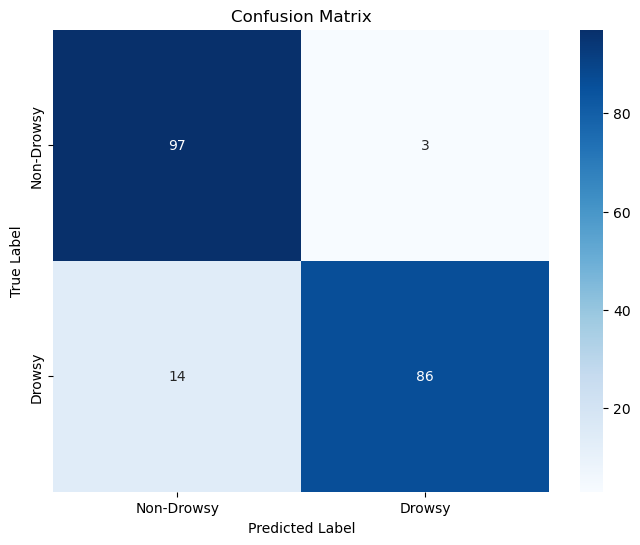

In [ ]:
########## confusion matrix ##########
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Drowsy', 'Drowsy'],
            yticklabels=['Non-Drowsy', 'Drowsy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
########## other metrics ##########

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = accuracy_score(true_labels, predicted_labels)


print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print("Accuracy:", accuracy)


Precision: 0.96217453456
Recall: 0.86
F1-Score: 0.9134
Accuracy: 0.91


In [27]:
########## Real time ditection ##########

import cv2
import numpy as np
from tensorflow import keras
import ipywidgets as widgets
from IPython.display import display, clear_output
import threading
import keyboard  
model = keras.models.load_model('drowsiness_detection_model_crnn.h5')

# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to perform drowsiness detection for a single frame
def detect_drowsiness(frame):
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    prediction = None
    for (x, y, w, h) in faces:
        # Crop and resize the face region to match the model's input shape
        face_roi = frame[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (227, 227))  
        face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB) 
        face_roi = np.expand_dims(face_roi, axis=0)  
        prediction = model.predict(face_roi)

        # Check if the model prediction is higher than 0.5 (drowsy)
        if prediction > 0.5:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(frame, 'Drowsy', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        else:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, 'Not Drowsy', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert the frame to RGB format for displaying with IPython
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    return frame_rgb, prediction

# Create a widget for displaying the video stream
video_widget = widgets.Image(format='jpeg', width=640, height=480)

# Display the widget in the Jupyter Notebook
display(video_widget)

# Open the camera
cap = cv2.VideoCapture(0)  # 0 for default camera, change it if you have multiple cameras

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform drowsiness detection for the current frame
    frame_rgb, prediction = detect_drowsiness(frame)

    # Display the video frame in the widget
    video_widget.value = bytes(cv2.imencode('.jpg', frame_rgb)[1])

    # Display the individual frame and prediction
    display(widgets.Image(value=bytes(cv2.imencode('.jpg', frame_rgb)[1]), format='jpeg'))
    
    if prediction is not None:
        print(f'Prediction: {prediction[0][0]:.4f}')

    # Check for key press 'q' and exit the loop
    if keyboard.is_pressed('q'):
        break

cap.release()



Image(value=b'', format='jpeg', height='480', width='640')